<a href="https://colab.research.google.com/github/shaikadish/imdbProject/blob/main/model_training_and_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd drive/MyDrive/GitHub/IMDB_project/imdbProject

Mounted at /content/drive
/content/drive/MyDrive/GitHub/IMDB_project/imdbProject


In [1]:
!pip install transformers

from transformers import BertTokenizer
import pandas as pd
import torch

     |████████████████████████████████| 4.2 MB 8.5 MB/s 
     |████████████████████████████████| 84 kB 1.3 MB/s 
     |████████████████████████████████| 596 kB 8.4 MB/s 
     |████████████████████████████████| 6.6 MB 37.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# ignore

In [94]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('fabriceyhc/bert-base-uncased-imdb', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/321 [00:00<?, ?B/s]

In [ ]:
review_data=pd.read_csv('review_data_learning.csv')
reviews=review_data['0'].to_list()
ratings=review_data['1'].to_list()

ParserError: ignored

In [ ]:
review=review_data.iloc[0,0]

print(tokenizer.encode(review, add_special_tokens=True,max_length=512,truncation=True))
# NEED TO PROCESS DATA TO BE <512 WORDS IN LENGTH.
review='[CLS] '+review.replace('.',' [SEP]')+'[PAD]'
# Print the original sentence.
print(' Original: ', review)

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(review))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(review)))

In [ ]:
import torch

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for review in reviews:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        review,                      # Sentence to encode.
                        truncation=True,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)
labels = torch.tensor(ratings)

# Print sentence 0, now as a list of IDs.
print('Original: ', reviews[0])
print('Token IDs:', input_ids[0])

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.7 * len(dataset))+1
val_size = int(0.5*(len(dataset) - train_size))
test_size = int(0.5*(len(dataset) - train_size))

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size,test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

In [ ]:
from torch.utils.data import DataLoader

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            shuffle=True,
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            batch_size = batch_size # Evaluate with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
import pickle


outfile = open('val_dataloader','wb')
pickle.dump(validation_dataloader,outfile)
outfile.close()

outfile = open('train_dataloader','wb')
pickle.dump(train_dataloader,outfile)
outfile.close()

outfile = open('test_dataloader','wb')
pickle.dump(test_dataloader,outfile)
outfile.close()

# continue

In [4]:
import pickle

infile = open('val_dataloader','rb')
validation_dataloader = pickle.load(infile)
infile.close()

infile = open('test_dataloader','rb')
test_dataloader = pickle.load(infile)
infile.close()

infile = open('train_dataloader','rb')
train_dataloader = pickle.load(infile)
infile.close()

In [5]:
import torch.nn as nn
from transformers import AutoModel

class RatingModel(nn.Module):
    def __init__(self):
        super(RatingModel, self).__init__()
        
        self.base_model = AutoModel.from_pretrained('fabriceyhc/bert-base-uncased-imdb')
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(768, 1) # output features from bert is 768 and 2 is ur number of labels
        
    def forward(self, input_ids, attn_mask):
        outputs = self.base_model(input_ids, attention_mask=attn_mask)
        # You write you new head here
        outputs = self.dropout(outputs[0])
        outputs = self.linear(outputs[:,0,:])
        
        return outputs

model = RatingModel()
model.cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

Downloading:   0%|          | 0.00/727 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at fabriceyhc/bert-base-uncased-imdb were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels =  1, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [6]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [7]:
def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [8]:
# STILL TO DO: FIGURE OUT HOW TO USE PRETRAINED FOR IMDB DATA? MAYBE UNNECESSARY
import time
import datetime

training_stats = []
total_t0=time.time()

for epoch in range(4):
    print("")
    print(f'======== Epoch {epoch+1} / {4} ========')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):


      # Progress update every 40 batches.
      if step % 40 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time()-t0)

        # Report progress.
        print(f'  Batch {step}  of  {len(train_dataloader)}.    Elapsed: {elapsed}.    Training Loss: {total_train_loss/step}.')

      b_input_ids = batch[0].cuda()
      b_input_mask = batch[1].cuda()
      b_labels = batch[2].cuda()/10
      '''
      loss, logits = model(b_input_ids,
                          token_type_ids=None,
                          attention_mask=b_input_mask,
                          labels=b_labels,
                          return_dict=False)
      '''
      preds=model(b_input_ids,b_input_mask)
      loss = criterion(preds.squeeze().cuda(), b_labels)

      total_train_loss += loss.item()

      del b_input_ids,b_input_mask,b_labels

      model.zero_grad()
      optimizer.zero_grad()

      # Perform a backward pass to calculate the gradients.
      loss.float().backward()

      # Clip the norm of the gradients to 1.0.
      # This is to help prevent the "exploding gradients" problem.
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Update parameters and take a step using the computed gradient.
      # The optimizer dictates the "update rule"--how the parameters are
      # modified based on their gradients, the learning rate, etc.
      optimizer.step()

      # Update the learning rate.
      #scheduler.step()


    scheduler.step()

    torch.save(model.state_dict(), f'imdb_{epoch}.pt')

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_loss = 0
    total_eval_r2=0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for step,batch in enumerate(validation_dataloader):


        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_labels = batch[2].cuda()/10

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            preds=model(b_input_ids,b_input_mask).cuda()

        loss = criterion(preds.squeeze(), b_labels)
        total_eval_r2+=r2_score(preds,b_labels)

        del b_input_ids,b_input_mask,b_labels

        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    avg_val_r2=total_eval_r2/ len(validation_dataloader)

    print("  RMSE: {0:.2f}".format(avg_val_loss**0.5))

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. R2':avg_val_r2,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

outfile = open('training_stats','wb')
pickle.dump(validation_dataloader,outfile)
outfile.close()

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))





======== Epoch 1 / 4 ========
  Batch 40  of  7334.    Elapsed: 0:00:33.    Training Loss: 0.23935628421604632.
  Batch 80  of  7334.    Elapsed: 0:01:06.    Training Loss: 0.16844645007513465.
  Batch 120  of  7334.    Elapsed: 0:01:39.    Training Loss: 0.13109115427359938.
  Batch 160  of  7334.    Elapsed: 0:02:12.    Training Loss: 0.1112440814380534.
  Batch 200  of  7334.    Elapsed: 0:02:45.    Training Loss: 0.09903655190020799.
  Batch 240  of  7334.    Elapsed: 0:03:18.    Training Loss: 0.09035455151461065.
  Batch 280  of  7334.    Elapsed: 0:03:50.    Training Loss: 0.08383637638097363.
  Batch 320  of  7334.    Elapsed: 0:04:23.    Training Loss: 0.07834344859584234.
  Batch 360  of  7334.    Elapsed: 0:04:56.    Training Loss: 0.07410561318716241.
  Batch 400  of  7334.    Elapsed: 0:05:29.    Training Loss: 0.07080644879490137.
  Batch 440  of  7334.    Elapsed: 0:06:02.    Training Loss: 0.06761700986799869.
  Batch 480  of  7334.    Elapsed: 0:06:35.    Training Los

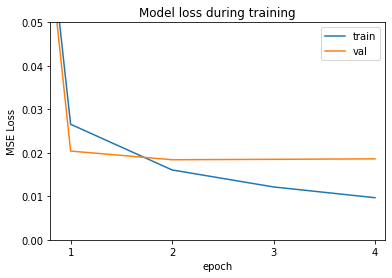

In [29]:
from matplotlib import pyplot as plt

validation_loss=[]
training_loss=[]

for epoch in training_stats:
  validation_loss.append(epoch['Valid. Loss'])
  training_loss.append(epoch['Training Loss'])

plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('Model loss during training')
plt.ylabel('MSE Loss')
plt.xlabel('epoch')
plt.xticks(ticks=[1,2,3,4])
plt.xlim((0.8,4.1))
plt.ylim((0,0.05))
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [35]:
# ========================================
#               Testing
# ========================================
# After the completion of each training epoch, measure our performance on
# our validation set.

print("")
print("Running Testing...")

t0 = time.time()

# Put the model in evaluation mode--the dropout layers behave differently
# during evaluation.
model.eval()

# Tracking variables
total_test_loss = 0
nb_eval_steps = 0

# Testing dictionary
testing_stats={'0.1':[],'0.2':[],'0.3':[],'0.4':[],'0.5':[],'0.6':[],'0.7':[],'0.8':[],'0.9':[],'1.0':[]}

# Evaluate data for one epoch
for step,batch in enumerate(test_dataloader):


    # Unpack this training batch from our dataloader.
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using
    # the `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids
    #   [1]: attention masks
    #   [2]: labels
    b_input_ids = batch[0].cuda()
    b_input_mask = batch[1].cuda()
    b_labels = batch[2].cuda()/10

    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():

        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        preds=model(b_input_ids,b_input_mask).cuda()

    for pred,label in zip(preds,b_labels):
      testing_stats[str(round(label.item(),1))].append(pred)

    loss = criterion(preds.squeeze(), b_labels)

    del b_input_ids,b_input_mask,b_labels

    # Accumulate the validation loss.
    total_test_loss += loss.item()
    
# Calculate the average loss over all of the batches.
avg_test_loss = total_test_loss / len(test_dataloader)

print("  RMSE: {0:.2f}".format(avg_test_loss**0.5))

# Measure how long the validation run took.
testing_time = format_time(time.time() - t0)

print("  Test Loss: {0:.2f}".format(avg_test_loss))
print("  Test took: {:}".format(testing_time))



Running Testing...
  RMSE: 0.13
  Test Loss: 0.02
  Test took: 0:06:58


In [36]:
avg_test_loss

0.01757990988089914

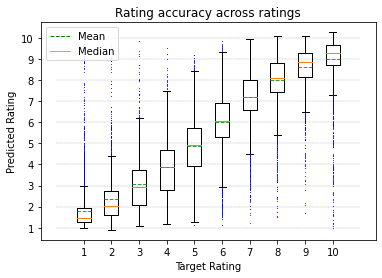

In [93]:
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')

data=[]
for rating in testing_stats:
  data.append(torch.tensor(testing_stats[rating]).cpu()*10)


meanlineprops = dict(linestyle='--', linewidth=1)
flierprops = dict(marker='o', markerfacecolor='blue', markersize=1,
                  markeredgecolor='none')
plt.yticks(ticks=[1,2,3,4,5,6,7,8,9,10])
plt.hlines([1,2,3,4,5,6,7,8,9,10],0,11,linestyles='--',linewidth=0.3,color='grey')
plt.boxplot(data,meanline=True,showmeans=True,meanprops=meanlineprops,flierprops=flierprops)

plt.xlabel('Target Rating')
plt.ylabel('Predicted Rating')
plt.title('Rating accuracy across ratings')

legend_elements = [Line2D([0], [0], color='g',linestyle='--', lw=1, label='Median'),Line2D([0], [0], color='orange', lw=1, label='Mean')]
plt.legend(legend_elements,['Mean','Median','Outliers'])

plt.show()

In [123]:
class RatingPredictor():
    def __init__(self,model,tokenizer):
      self.model=model.eval()
      self.tokenizer=tokenizer

    def predict(self,review):
      encoded_dict = self.tokenizer.encode_plus(
                        review,                      # Sentence to encode.
                        truncation=True,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
      # Add the encoded sentence to the list.    
      input_ids=encoded_dict['input_ids']
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_mask=encoded_dict['attention_mask']

      preds=model(torch.tensor([input_ids]).cuda(),torch.tensor([attention_mask]).cuda())

      return round(preds.item()*10)
      


In [128]:
predictor=RatingPredictor(model,tokenizer)
review=input("Type a review: \n")
prediction=predictor.predict(review)
print(f'Predicted rating: {prediction}/10')

Type a review: 
The new Batman movie is good, but it doesn't hold a candle to the Christopher Nolan movies. The action is fantastic, and Robert Patinson does a good job, bud you can't shake the feeling that you've seen it before. The psychological aspect was done better in the Dark Knight, and the villain just feels like a Joker rip off. All that said, as a movie it still delivers thrills, and I would recommend it to fans of comic movies.
Predicted rating: 7/10
